In [1]:
import sys
import numpy as np
import os
import cv2
import h5py
import logging
import tensorflow as tf
from math import log10
from collections import OrderedDict

import matplotlib.pyplot as plt
from typing import Iterator, Tuple
from dataset_generator import DatasetGenerator
from layers import weight_variable,bias_variable,conv2d,weight_variable_devonc,deconv2d,max_pool,pixel_wise_softmax,cross_entropy,features_concat,pixel_wise_softmax_2

/home/s161362/.conda/envs/env_dhi/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
##########
GLOBAL_PATH='MODEL_FIRST_120/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        
#############
PATH_TRAINING='TRAINING/'
PATH_VALIDATION='VALIDATION/'
PATH_TEST='TEST/'

PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
##############

        
INPUT_CHANNELS=9
OUTPUT_CHANNELS=1
NB_CLASSES=2

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'SRCNN.ckpt'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=200
DROPOUT=0.85
DEFAULT_BATCH_SIZE = 50
DEFAULT_EPOCHS = 25#5
DEFAULT_ITERATIONS =98#98
DEFAULT_VALID=70#70
DISPLAY_STEP=30

In [3]:
def create_conv_net(x, keep_prob, channels, n_class, layers=4, features_root=32, filter_size=3, pool_size=2,phase_train=True):
    """
    Creates a new convolutional unet for the given parametrization.
    
    :param x: input tensor, shape [?,nx,ny,channels]
    :param keep_prob: dropout probability tensor
    :param channels: number of channels in the input image
    :param n_class: number of output labels
    :param layers: number of layers in the net
    :param features_root: number of features in the first layer
    :param filter_size: size of the convolution filter
    :param pool_size: size of the max pooling operation
    """

    logging.info("Layers {layers}, features {features}, filter size {filter_size}x{filter_size}, pool size: {pool_size}x{pool_size}".format(layers=layers,
                                                                                                           features=features_root,
                                                                                                           filter_size=filter_size,
                                                                                                           pool_size=pool_size))
    # Placeholder for the input image
    nx = tf.shape(x)[1]
    ny = tf.shape(x)[2]
    x_image = tf.reshape(x, tf.stack([-1,nx,ny,channels]))
    in_node = x_image
    batch_size = tf.shape(x_image)[0]
 
    weights = []
    biases = []
    convs = []
    pools = OrderedDict()
    deconv = OrderedDict()
    dw_h_convs = OrderedDict()
    up_h_convs = OrderedDict()
    
    in_size = 1000
    size = in_size
    # down layers
    for layer in range(0, layers):
        features = 2**layer*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        if layer == 0:
            w1 = weight_variable([filter_size, filter_size, channels, features], stddev)
        else:
            w1 = weight_variable([filter_size, filter_size, features//2, features], stddev)
            
        w2 = weight_variable([filter_size, filter_size, features, features], stddev)
        b1 = bias_variable([features])
        b2 = bias_variable([features])
        

        conv1 = conv2d(in_node, w1, keep_prob)
        conv1=tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=phase_train)
        tmp_h_conv = tf.nn.relu(conv1 + b1)
        conv2 = conv2d(tmp_h_conv, w2, keep_prob)
        conv2=tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=phase_train)
        dw_h_convs[layer] = tf.nn.relu(conv2 + b2)
        
        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size -= 4
        if layer < layers-1:
            pools[layer] = max_pool(dw_h_convs[layer], pool_size)
            in_node = pools[layer]
            size /= 2
        
    in_node = dw_h_convs[layers-1]

    # up layers
    for layer in range(layers-2, -1, -1):
        features = 2**(layer+1)*features_root
        stddev = np.sqrt(2 / (filter_size**2 * features))
        
        wd = weight_variable_devonc([pool_size, pool_size, features//2, features], stddev)
        bd = bias_variable([features//2])
        h_deconv = tf.nn.relu(deconv2d(in_node, wd, pool_size) + bd)
        h_deconv_concat = features_concat(dw_h_convs[layer], h_deconv)
        deconv[layer] = h_deconv_concat
        
        w1 = weight_variable([filter_size, filter_size, features, features//2], stddev)
        w2 = weight_variable([filter_size, filter_size, features//2, features//2], stddev)
        b1 = bias_variable([features//2])
        b2 = bias_variable([features//2])
        
        conv1 = conv2d(h_deconv_concat, w1, keep_prob)
        conv1=tf.contrib.layers.batch_norm(conv1, center=True, scale=True, is_training=phase_train)
        h_conv = tf.nn.relu(conv1 + b1)
        conv2 = conv2d(h_conv, w2, keep_prob)
        conv2=tf.contrib.layers.batch_norm(conv2, center=True, scale=True, is_training=phase_train)
        in_node = tf.nn.relu(conv2 + b2)
        up_h_convs[layer] = in_node

        weights.append((w1, w2))
        biases.append((b1, b2))
        convs.append((conv1, conv2))
        
        size *= 2
        size -= 4

    # Output Map
    weight = weight_variable([1, 1, features_root, n_class], stddev)
    bias = bias_variable([n_class])
    conv = conv2d(in_node, weight, tf.constant(1.0))
    conv=tf.contrib.layers.batch_norm(conv, center=True, scale=True, is_training=phase_train)
    output_map = tf.nn.relu(conv + bias)
    up_h_convs["out"] = output_map
    

    variables = []
    for w1,w2 in weights:
        variables.append(w1)
        variables.append(w2)
        
    for b1,b2 in biases:
        variables.append(b1)
        variables.append(b2)
    
    
    return output_map, variables, int(in_size - size)



In [4]:
class CustomCNN():
    
    def __init__(self, channels=9, n_class=2, cost_kwargs={}, **kwargs):
        """
        Initializes the custom CNN 
        """
        self.n_class = n_class
        tf.reset_default_graph()
        
        self.X_placeholder = tf.placeholder(tf.float32, [None, None, None, INPUT_CHANNELS], name='X_placeholder')
        self.y_placeholder = tf.placeholder(tf.float32, [None, None, None,NB_CLASSES], name='y_placeholder')
        self.keep_prob = tf.placeholder(tf.float32)
        self.phase_train = tf.placeholder(tf.bool, name='phase_train')

        logits, self.variables, self.offset = create_conv_net(self.X_placeholder, self.keep_prob, channels, n_class, **kwargs)
        
        self.cross_entropy = tf.reduce_mean(cross_entropy(tf.reshape(self.y_placeholder, [-1, n_class]),
                                                          tf.reshape(pixel_wise_softmax_2(logits), [-1, n_class])))
        self.cost=self.cross_entropy
        self.gradients_node = tf.gradients(self.cross_entropy, self.variables)
        
        self.predicter = pixel_wise_softmax_2(logits)
        self.correct_pred = tf.equal(tf.argmax(self.predicter, 3), tf.argmax(self.y_placeholder, 3))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        
        
    def save(self, sess,saver, model_path,step):
        """
        Saves the current session to a checkpoint
        
        :param sess: current session
        :param saver: saver of the model
        :param model_path: path to file system location
        :step: step of the iterations during training when the model is stored
        """
       
        save_path=saver.save(sess, model_path,global_step=step)
        
        return save_path

    
    def restore(self, sess,saver, model_path):
        """
        Restores a session from a checkpoint
        
        :param sess: current session instance
        :param saver: saver of the model
        :param model_path: path to file system checkpoint location
        """

        print("Reading checkpoints...")
        saver.restore(sess, model_path)
        summary="Model restored from file: %s" % (model_path)
        print(summary)
        return True
        
    def predict(self, model_path, x_test):
        """
        Uses the model to create a prediction for the given data
        
        :param model_path: path to the model checkpoint to restore
        :param x_test: Data to predict on. Shape [n, nx, ny, channels]
        :returns prediction: The unet prediction Shape [n, px, py, labels] (px=nx-self.offset/2) 
        """
        
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            # Initialize variables
            sess.run(init)
        
            # Restore model weights from previously saved model
            self.restore(sess, model_path)
            
            y_dummy = np.empty((x_test.shape[0], x_test.shape[1], x_test.shape[2], self.n_class))
            prediction = sess.run(self.predicter, feed_dict={self.X_placeholder: x_test, self.y_placeholder: y_dummy, self.keep_prob: 1.})
            
        return prediction
        
        
       

In [5]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param optimizer: (optional) name of the optimizer to use (momentum or adam)
    :param opt_kwargs: (optional) kwargs passed to the learning rate (momentum opt) and to the optimizer ->learning_rate, decay_rate,momentum (momentum) or learning_rate (adam)   
    """
    def __init__(self, net, batch_size=30, optimizer="adam", opt_kwargs={}):
        self.net = net
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        
    def _get_optimizer(self, training_iters, global_step):
        if self.optimizer == "momentum":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.2)
            decay_rate = self.opt_kwargs.pop("decay_rate", 0.95)
            momentum = self.opt_kwargs.pop("momentum", 0.2)
            
            self.learning_rate_node = tf.train.exponential_decay(learning_rate=learning_rate, 
                                                        global_step=global_step, 
                                                        decay_steps=training_iters,  
                                                        decay_rate=decay_rate, 
                                                        staircase=True)
            
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate_node, momentum=momentum,
                                                   **self.opt_kwargs).minimize(self.net.cost,global_step=global_step)
        elif self.optimizer == "adam":
            learning_rate = self.opt_kwargs.pop("learning_rate", 0.00001)
            self.learning_rate_node = tf.Variable(learning_rate)
            
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate_node, 
                                               **self.opt_kwargs).minimize(self.net.cost,global_step=global_step)
        return optimizer
    
    def _initialize(self, training_iters, output_path, restore, prediction_path):
        global_step = tf.Variable(0)
        
        self.norm_gradients_node = tf.Variable(tf.constant(0.0, shape=[len(self.net.gradients_node)]))

        self.optimizer = self._get_optimizer(training_iters, global_step)        
        init = tf.global_variables_initializer()
        
        self.prediction_path = prediction_path
        
        
        
        
        return init
    
    def train(self, data_provider_path, save_path='', restore_path='', training_iters=4, epochs=3, dropout=0.75, display_step=1, validation_batch_size=30,restore=False,rec_save=1, prediction_path = ''):
        """
        Lauches the training process
        
        :param data_provider_path: where the DATASET folder is
        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param training_iters: number of training mini batch iteration
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        
        PATH_TRAINING=data_provider_path+'TRAINING/'
        PATH_VALIDATION=data_provider_path+'VALIDATION/'
        PATH_TEST=data_provider_path+'TEST/'
        
        #STORE PSNR for ANALYSIS
        loss_train=np.zeros(training_iters*epochs)
        file_train = open(data_provider_path+'loss_train.txt','w') 
        loss_verif=np.zeros(epochs)
        file_verif = open(data_provider_path+'loss_verif.txt','w') 
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        init = self._initialize(training_iters, save_path, restore, prediction_path)
        saver = tf.train.Saver()
        with tf.Session() as sess:        
            sess.run(init)
            
            if restore:
                self.net.restore(sess,saver,restore_path )
            else:
                sess.run(init)

            

            val_generator = DatasetGenerator.from_root_folder(PATH_VALIDATION, batch_size=validation_batch_size)
            val_generator=val_generator.shuffled()
            val_generator=val_generator.__iter__()
            X_val,Y_val=val_generator.__next__()
            X_val=standardize(X_val)
            
            self.store_prediction(sess, X_val, Y_val, "_init",validation_batch_size)
            
            train_len = self.batch_size*training_iters
            training_generator = DatasetGenerator.from_root_folder(PATH_TRAINING, batch_size=self.batch_size)
            
            logging.info("Start optimization")
            
            avg_gradients = None
            counter=0
            for epoch in range(epochs):
                total_loss = 0
                training_generator_ite=training_generator.shuffled()
                training_generator_ite=training_generator_ite.__iter__()
                
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
    
                    batch_x,batch_y =training_generator_ite.__next__()
                    batch_x=standardize(batch_x)
                    
                    # Run optimization op (backprop)
                    _, loss, lr, gradients = sess.run((self.optimizer, self.net.cost, self.learning_rate_node, self.net.gradients_node), 
                                                      feed_dict={self.net.X_placeholder: batch_x,
                                                                 self.net.y_placeholder: batch_y,
                                                                 self.net.keep_prob: dropout,self.net.phase_train:True})
                  
                    avg_gradients = _update_avg_gradients(avg_gradients, gradients, step)
                    norm_gradients = [np.linalg.norm(gradient) for gradient in avg_gradients]
                    self.norm_gradients_node.assign(norm_gradients).eval()
                    
                    if step % display_step == 0:
                        self.output_minibatch_stats(sess, step, batch_x,batch_y)
                        
                    total_loss += loss
                    loss_train[counter]=loss
                    file_train.write(str(loss_train[counter])+'\n')
                    counter += 1
                    if counter % rec_save == 0:
                        save_path=self.net.save(sess,saver,save_path, counter)
                        
                    

                self.output_epoch_stats(epoch, total_loss, training_iters, lr)
                
                loss_v=self.store_prediction(sess, X_val, Y_val, "epoch_%s"%epoch,validation_batch_size)
                loss_verif[epoch]=loss_v
                file_verif.write(str(loss_verif[epoch])+'\n')
                
            logging.info("Optimization Finished!")
            
            return save_path, loss_train,loss_verif
        
    def store_prediction(self, sess, batch_x, batch_y, name,validation_batch_size):
        prediction = sess.run(self.net.predicter, feed_dict={self.net.X_placeholder: batch_x, 
                                                             self.net.y_placeholder: batch_y, 
                                                             self.net.keep_prob: 1.,self.net.phase_train:False})
        
        loss = sess.run(self.net.cost, feed_dict={self.net.X_placeholder: batch_x, 
                                                       self.net.y_placeholder: batch_y, 
                                                       self.net.keep_prob: 1.,self.net.phase_train:False})

        logging.info("Verification error= {:.1f}%, loss= {:.4f}".format(error_rate(prediction,batch_y),loss))
        
        plot_summary(prediction,batch_y,validation_batch_size,name,self.prediction_path)
        return loss

    def output_epoch_stats(self, epoch, total_loss, training_iters, lr):
        logging.info("Epoch {:}, Average loss: {:.4f}, learning rate: {:.4f}".format(epoch, (total_loss / training_iters), lr))

    def output_minibatch_stats(self, sess, step, batch_x, batch_y):
        # Calculate batch loss and accuracy
        loss, acc, predictions = sess.run([self.net.cost,self.net.accuracy, 
                                                            self.net.predicter], 
                                                           feed_dict={self.net.X_placeholder: batch_x,
                                                                      self.net.y_placeholder: batch_y,
                                                                      self.net.keep_prob: 1.,self.net.phase_train:False})
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Training Accuracy= {:.4f}, Minibatch error= {:.1f}%".format(step,
                                                                                                                    loss,
                                                                                                                    acc,
                                                                                                                    error_rate(predictions, batch_y)))

In [6]:
def standardize(data):
    '''
    Standardize the input data of the network
    :param data to be standardized (size nb_batches x WIDTH x HEIGHT x number of channels) 
    
    returns data standardized size nb_batches x WIDTH x HEIGHT x number of channels 
    
    '''
    WIDTH=data.shape[1]
    HEIGHT=data.shape[2]
    channels=data.shape[3]
    
    mean_t=np.mean(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    std_t=np.std(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=data-mean_t/std_t
    
    #For normalization 
    min_t=np.amin(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    max_t=np.amax(np.reshape(data,[len(data)*WIDTH*HEIGHT,channels]), axis=0)
    data=(data-min_t)/(max_t-min_t)

    return data

def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,batch_size,epoch,prediction_path):
    
    
    fig1, axs1 = plt.subplots(1, batch_size,figsize=(8*batch_size,8))
    suptitle = fig1.suptitle(epoch+' Groundtruth ', fontsize='large')
    fig2, axs2 = plt.subplots(1, batch_size,figsize=(batch_size*8,8))
    suptitle2 = fig2.suptitle(epoch+' Predictions ', fontsize='large')
    for i in range(batch_size):
        
        axs1[i].imshow(labels[i,:,:,0])
        plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i,:,:,0])
        logits=np.argmax(predictions, 3)
        axs2[i].imshow(1-logits[i,:,:])
        plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',labels[i,:,:,0])

    plt.subplots_adjust()
#     suptitle.set_y(0.95)
#     fig.subplots_adjust(top=0.96)
    plt.show()
    plt.show()

def _update_avg_gradients(avg_gradients, gradients, step):
    if avg_gradients is None:
        avg_gradients = [np.zeros_like(gradient) for gradient in gradients]
    for i in range(len(gradients)):
        avg_gradients[i] = (avg_gradients[i] * (1.0 - (1.0 / (step+1)))) + (gradients[i] / (step+1))
        
    return avg_gradients


2018-03-08 22:09:52,499 Layers 4, features 32, filter size 3x3, pool size: 2x2
2018-03-08 22:10:13,078 Verification error= 72.1%, loss= 0.3807


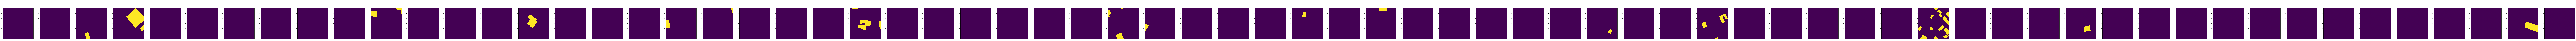

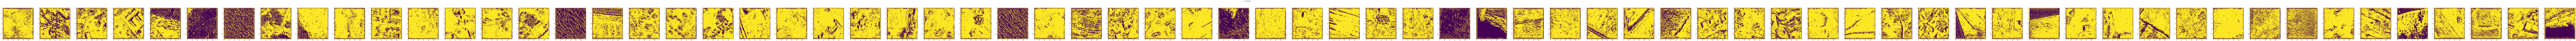

2018-03-08 22:10:32,109 Start optimization
2018-03-08 22:10:34,577 Iter 0, Minibatch Loss= 0.3693, Training Accuracy= 0.2890, Minibatch error= 71.1%
2018-03-08 22:11:04,002 Iter 30, Minibatch Loss= 0.3723, Training Accuracy= 0.2777, Minibatch error= 72.2%
2018-03-08 22:11:33,747 Iter 60, Minibatch Loss= 0.3652, Training Accuracy= 0.3292, Minibatch error= 67.1%
2018-03-08 22:12:04,198 Iter 90, Minibatch Loss= 0.3530, Training Accuracy= 0.3423, Minibatch error= 65.8%
2018-03-08 22:12:11,232 Epoch 0, Average loss: 0.3831, learning rate: 0.0000
2018-03-08 22:12:11,695 Verification error= 63.9%, loss= 0.3566


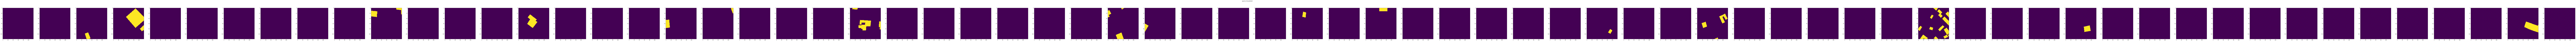

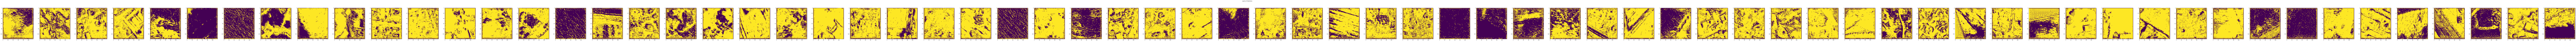

2018-03-08 22:12:51,896 Iter 120, Minibatch Loss= 0.3506, Training Accuracy= 0.3845, Minibatch error= 61.5%
2018-03-08 22:13:22,283 Iter 150, Minibatch Loss= 0.3460, Training Accuracy= 0.3972, Minibatch error= 60.3%
2018-03-08 22:13:52,330 Iter 180, Minibatch Loss= 0.3465, Training Accuracy= 0.3929, Minibatch error= 60.7%
2018-03-08 22:14:07,434 Epoch 1, Average loss: 0.3676, learning rate: 0.0000
2018-03-08 22:14:07,864 Verification error= 61.4%, loss= 0.3373


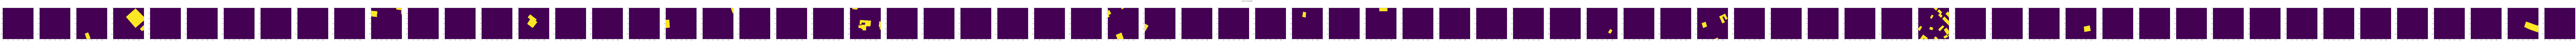

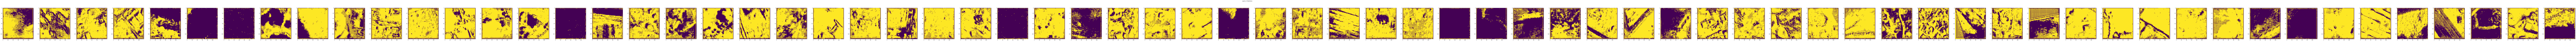

2018-03-08 22:14:42,042 Iter 210, Minibatch Loss= 0.3322, Training Accuracy= 0.4145, Minibatch error= 58.6%
2018-03-08 22:15:13,039 Iter 240, Minibatch Loss= 0.3277, Training Accuracy= 0.3936, Minibatch error= 60.6%
2018-03-08 22:15:44,951 Iter 270, Minibatch Loss= 0.3221, Training Accuracy= 0.4150, Minibatch error= 58.5%
2018-03-08 22:16:09,404 Epoch 2, Average loss: 0.3462, learning rate: 0.0000
2018-03-08 22:16:09,860 Verification error= 56.5%, loss= 0.3205


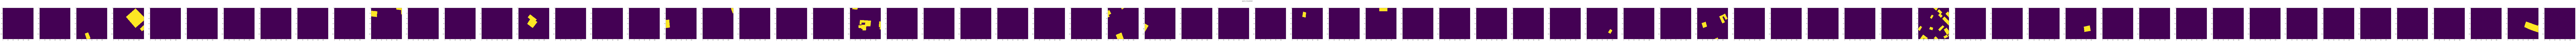

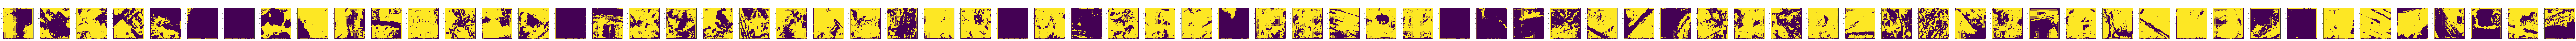

2018-03-08 22:16:34,692 Iter 300, Minibatch Loss= 0.3151, Training Accuracy= 0.4479, Minibatch error= 55.2%
2018-03-08 22:17:04,602 Iter 330, Minibatch Loss= 0.3195, Training Accuracy= 0.4224, Minibatch error= 57.8%
2018-03-08 22:17:35,827 Iter 360, Minibatch Loss= 0.3047, Training Accuracy= 0.5117, Minibatch error= 48.8%
2018-03-08 22:18:06,385 Iter 390, Minibatch Loss= 0.3070, Training Accuracy= 0.5253, Minibatch error= 47.5%
2018-03-08 22:18:07,442 Epoch 3, Average loss: 0.3263, learning rate: 0.0000
2018-03-08 22:18:07,887 Verification error= 48.4%, loss= 0.3065


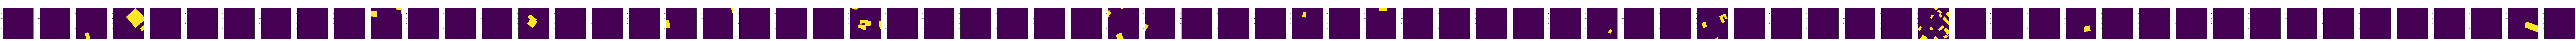

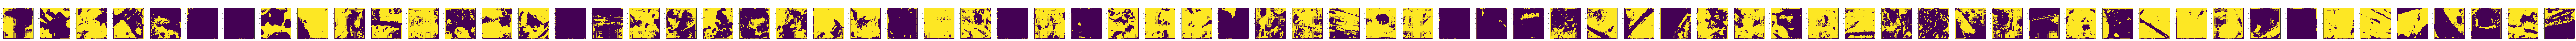

2018-03-08 22:18:55,314 Iter 420, Minibatch Loss= 0.3048, Training Accuracy= 0.4969, Minibatch error= 50.3%
2018-03-08 22:19:25,930 Iter 450, Minibatch Loss= 0.2866, Training Accuracy= 0.5525, Minibatch error= 44.7%
2018-03-08 22:19:56,556 Iter 480, Minibatch Loss= 0.2917, Training Accuracy= 0.5674, Minibatch error= 43.3%
2018-03-08 22:20:05,804 Epoch 4, Average loss: 0.3083, learning rate: 0.0000
2018-03-08 22:20:06,229 Verification error= 43.7%, loss= 0.2925


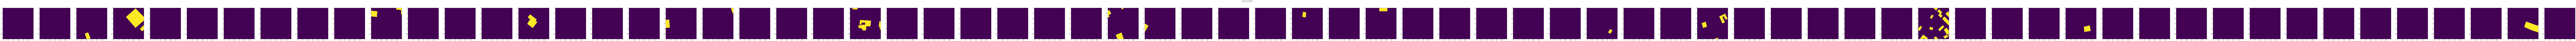

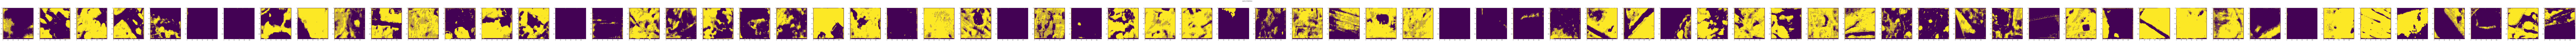

2018-03-08 22:20:45,411 Iter 510, Minibatch Loss= 0.2821, Training Accuracy= 0.5843, Minibatch error= 41.6%
2018-03-08 22:21:15,755 Iter 540, Minibatch Loss= 0.2690, Training Accuracy= 0.5567, Minibatch error= 44.3%
2018-03-08 22:21:47,409 Iter 570, Minibatch Loss= 0.2830, Training Accuracy= 0.5547, Minibatch error= 44.5%
2018-03-08 22:22:04,877 Epoch 5, Average loss: 0.2941, learning rate: 0.0000
2018-03-08 22:22:05,301 Verification error= 41.1%, loss= 0.2794


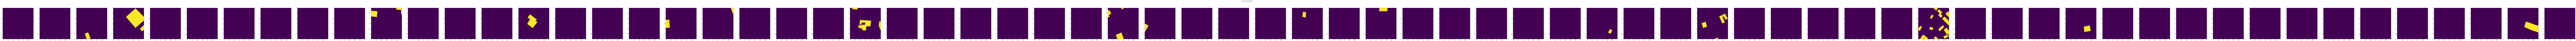

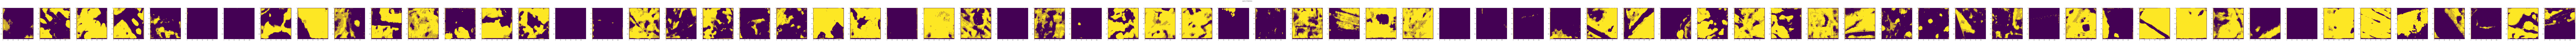

2018-03-08 22:22:37,602 Iter 600, Minibatch Loss= 0.2864, Training Accuracy= 0.5576, Minibatch error= 44.2%
2018-03-08 22:23:08,368 Iter 630, Minibatch Loss= 0.2831, Training Accuracy= 0.5814, Minibatch error= 41.9%
2018-03-08 22:23:40,642 Iter 660, Minibatch Loss= 0.2780, Training Accuracy= 0.6138, Minibatch error= 38.6%
2018-03-08 22:24:06,833 Epoch 6, Average loss: 0.2880, learning rate: 0.0000
2018-03-08 22:24:07,257 Verification error= 98.6%, loss= 0.3466


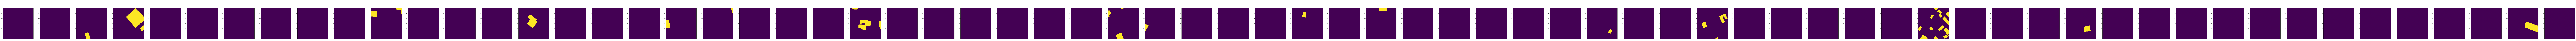

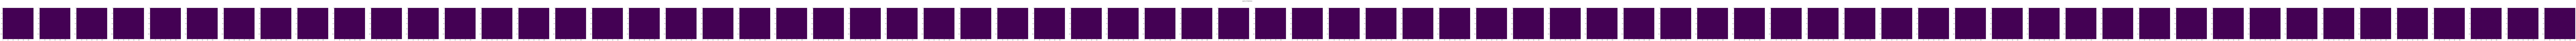

2018-03-08 22:24:30,186 Iter 690, Minibatch Loss= 0.3466, Training Accuracy= 0.0238, Minibatch error= 97.6%
2018-03-08 22:24:59,683 Iter 720, Minibatch Loss= 0.3466, Training Accuracy= 0.0108, Minibatch error= 98.9%
2018-03-08 22:25:30,563 Iter 750, Minibatch Loss= 0.3466, Training Accuracy= 0.0131, Minibatch error= 98.7%
2018-03-08 22:26:02,830 Iter 780, Minibatch Loss= 0.3466, Training Accuracy= 0.0150, Minibatch error= 98.5%
2018-03-08 22:26:06,072 Epoch 7, Average loss: 0.3466, learning rate: 0.0000
2018-03-08 22:26:06,489 Verification error= 98.6%, loss= 0.3466


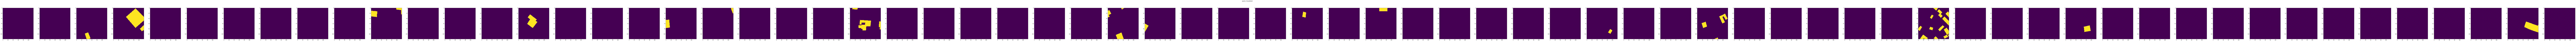

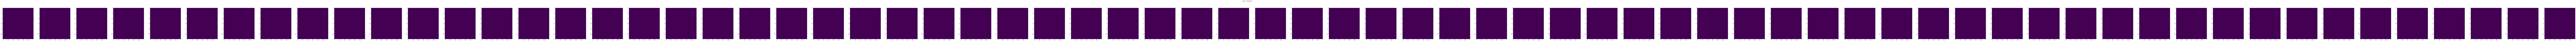

2018-03-08 22:26:52,601 Iter 810, Minibatch Loss= 0.3466, Training Accuracy= 0.0170, Minibatch error= 98.3%
2018-03-08 22:27:24,289 Iter 840, Minibatch Loss= 0.3466, Training Accuracy= 0.0122, Minibatch error= 98.8%
2018-03-08 22:27:56,460 Iter 870, Minibatch Loss= 0.3466, Training Accuracy= 0.0073, Minibatch error= 99.3%
2018-03-08 22:28:08,241 Epoch 8, Average loss: 0.3466, learning rate: 0.0000
2018-03-08 22:28:08,652 Verification error= 98.6%, loss= 0.3466


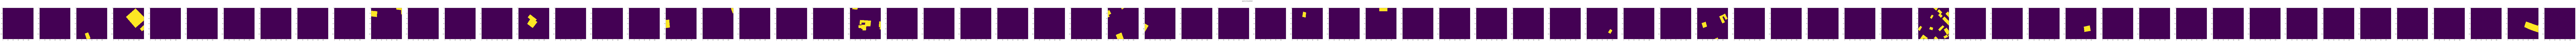

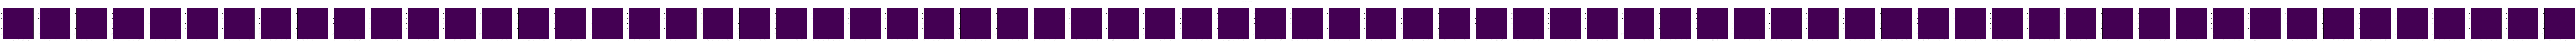

2018-03-08 22:28:46,456 Iter 900, Minibatch Loss= 0.3466, Training Accuracy= 0.0235, Minibatch error= 97.7%


KeyboardInterrupt: 

In [7]:
if __name__ == '__main__':
    model = CustomCNN()


    root_folder = '../DATA_GHANA/DATASET/120_x_120_8_bands/'
    
    trainer=Trainer(model,DEFAULT_BATCH_SIZE)
    save_path,loss_train,loss_verif=trainer.train( root_folder, MODEL_PATH_SAVE, '', DEFAULT_ITERATIONS,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,False,REC_SAVE, TEST_SAVE)
    
    #SAVE PSNR
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,DEFAULT_EPOCHS*DEFAULT_ITERATIONS,1)
    epo=np.arange((DEFAULT_ITERATIONS-1),(DEFAULT_EPOCHS*DEFAULT_ITERATIONS+(DEFAULT_ITERATIONS-1)),DEFAULT_ITERATIONS)
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')
    plt.show()
    
    